# <center>House Prices — Advanced Regression Techniques


# 🏡 House Prices — EDA

Objective: analyze a dataset of house sales and identify key features that influence the price (`SalePrice`).

We will consider:
- price distribution
- dependencies between features
- correlations
- gaps and anomalies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

sns.set_theme(style='darkgrid')

In [2]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


## Missing values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
df.loc[:, df.columns[df.isna().any()]].isna().sum()

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Some features contain a large number of missing values. For example:

- `Alley`, `PoolQC`, `Fence`, `MiscFeature` — >90% missing values
- `LotFrontage`, `MasVnrType`, `FireplaceQu` — moderate number of missing values

 These features are either removed or processed separately (e.g. filled with "None" or median).

## SalePrice Distribution

In [5]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head(10)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
5,6,50,85.0,14115,5,5,1993,1995,0.0,732,...,40,30,0,320,0,0,700,10,2009,143000
6,7,20,75.0,10084,8,5,2004,2005,186.0,1369,...,255,57,0,0,0,0,0,8,2007,307000
7,8,60,NaN,10382,7,6,1973,1973,240.0,859,...,235,204,228,0,0,0,350,11,2009,200000
8,9,50,51.0,6120,7,5,1931,1950,0.0,0,...,90,0,205,0,0,0,0,4,2008,129900
9,10,190,50.0,7420,5,6,1939,1950,0.0,851,...,0,4,0,0,0,0,0,1,2008,118000


In [6]:
df[['SalePrice', 'LotArea', 'YearBuilt']].describe()

,SalePrice,LotArea,YearBuilt
count,1460.000000,1460.000000,1460.000000
mean,180921.195890,10516.828082,1971.267808
std,79442.502883,9981.264932,30.202904
min,34900.000000,1300.000000,1872.000000
25%,129975.000000,7553.500000,1954.000000
50%,163000.000000,9478.500000,1973.000000
75%,214000.000000,11601.500000,2000.000000
max,755000.000000,215245.000000,2010.000000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


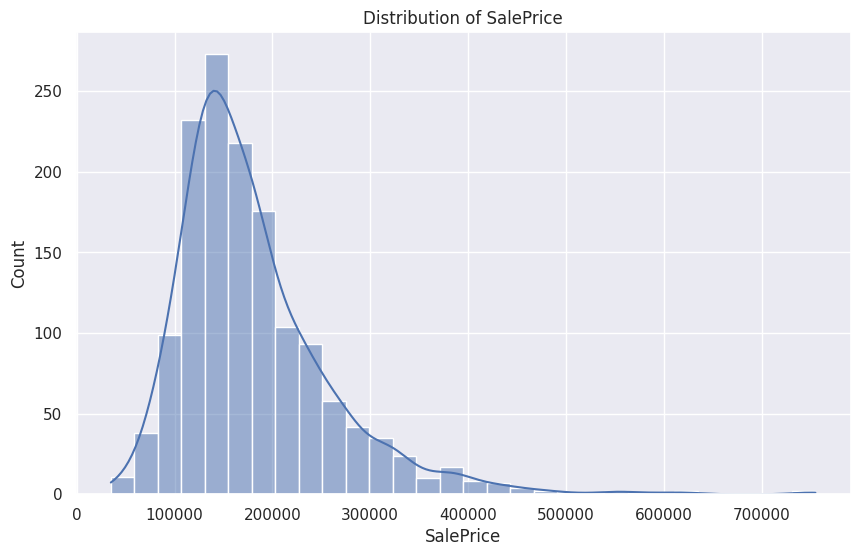

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], bins=30,  kde=True)
plt.title('Distribution of SalePrice')
plt.show()

House prices are distributed with a right tail (unevenly). This is typical for monetary indicators.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


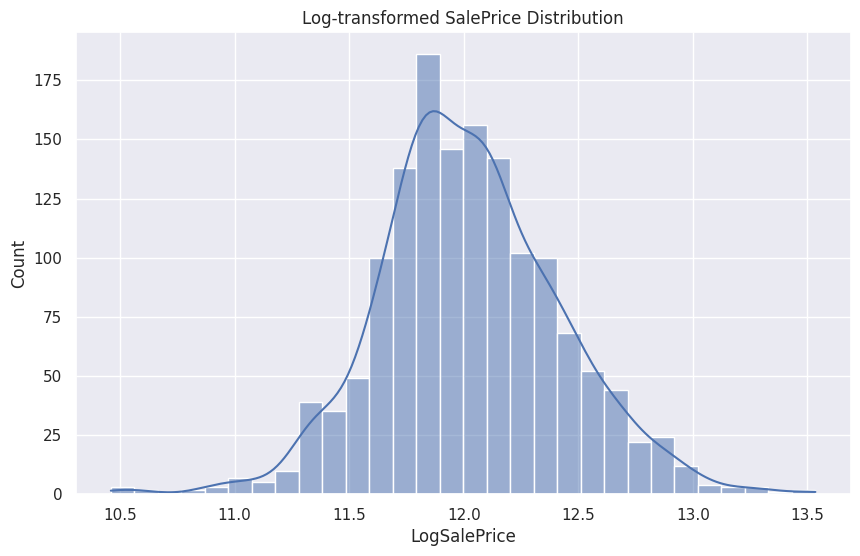

In [8]:
df['LogSalePrice'] = np.log1p(df['SalePrice'])

plt.figure(figsize=(10, 6))
sns.histplot(df['LogSalePrice'], bins=30, kde=True)
plt.title('Log-transformed SalePrice Distribution')
plt.show()


We also built a logarithmic distribution (`log(SalePrice + 1)`), which is closer to normal and improves the performance of the models.

### SalePrice by OverallQual

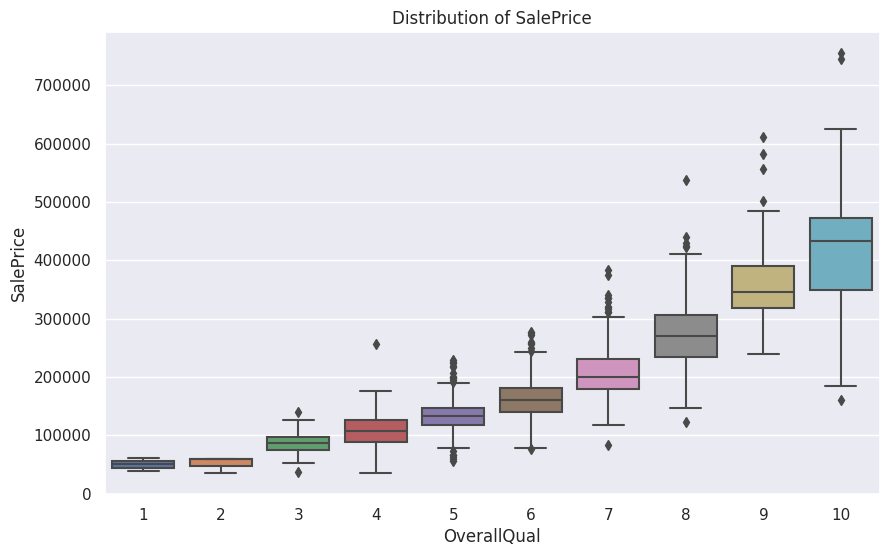

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=df)
plt.title('Distribution of SalePrice')
plt.show()

The graph shows that as `OverallQual` (the overall quality of the house) increases, the median price increases significantly.

- Houses with quality 9-10 cost on average 2-3 times more than houses with quality 5.
- There is a clear dependence, which makes this feature important for the model.

### Price distribution by decade of construction (YearBuilt → Decade)

To eliminate the overload of the graph when using `YearBuilt`, we combined years into decades. This allowed us to more clearly trace the trend of housing prices depending on the period of construction.

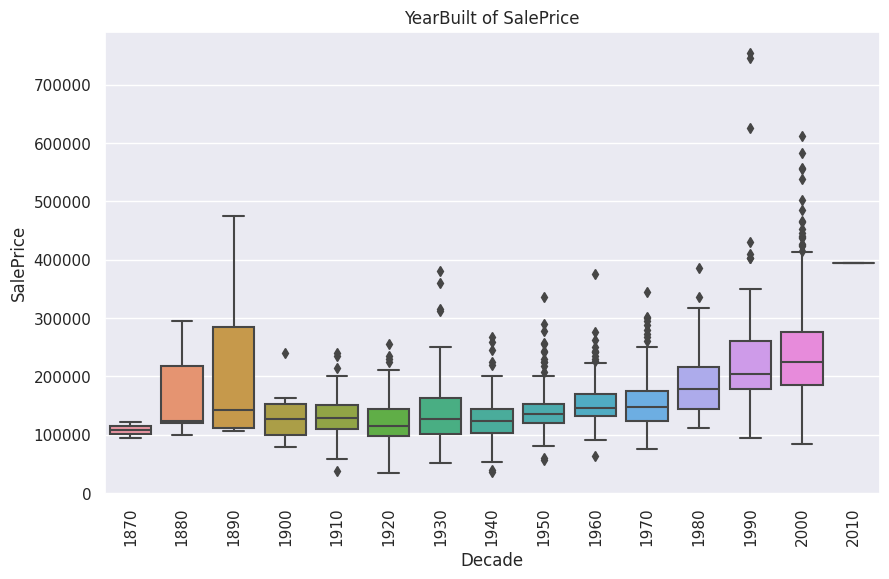

In [10]:
df['Decade'] = (df['YearBuilt'] // 10) * 10

plt.figure(figsize=(10, 6))
sns.boxplot(x='Decade', y='SalePrice', data=df)
plt.xticks(rotation=90)
plt.title('YearBuilt of SalePrice')
plt.show()

The chart shows:
- As the decades go by, **median sales price increases**.
- **Price ranges become wider** starting in the 1990s, indicating a greater diversity of properties on the market.
- Homes built before the 1940s **remain lower**, which makes sense given the age and condition of the properties.

## Correlations with SalePrice



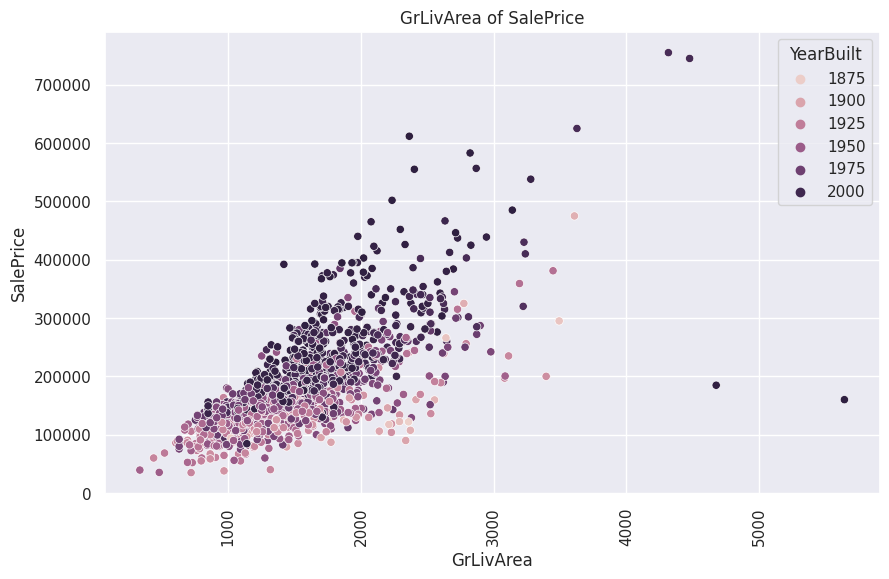

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='YearBuilt', data=df)
plt.xticks(rotation=90)
plt.title('GrLivArea of SalePrice')
plt.show()

In [12]:
def Pearson_correlation(X,Y):
    if len(X)==len(Y):
        Sum_xy = sum((X-X.mean())*(Y-Y.mean()))
        Sum_x_squared = sum((X-X.mean())**2)
        Sum_y_squared = sum((Y-Y.mean())**2)       
        corr = Sum_xy / np.sqrt(Sum_x_squared * Sum_y_squared)
    return corr
            
print(Pearson_correlation(df['GrLivArea'],df['SalePrice']))    
print(Pearson_correlation(df['YearBuilt'],df['SalePrice']))    

0.7086244776126511
0.5228973328794967


In [13]:
corr = df.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)
print(corr.head(15))


SalePrice       1.000000
LogSalePrice    0.948374
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Decade          0.515824
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Name: SalePrice, dtype: float64


The strongest positive correlations with price:

- `OverallQual` — 0.79 (house quality)
- `GrLivArea` — 0.71 (above ground living area)
- `GarageCars`, `GarageArea`, `TotalBsmtSF` — > 0.6

There is also a weak correlation with `YearBuilt`, `FullBath`.

These features should be left in the model.

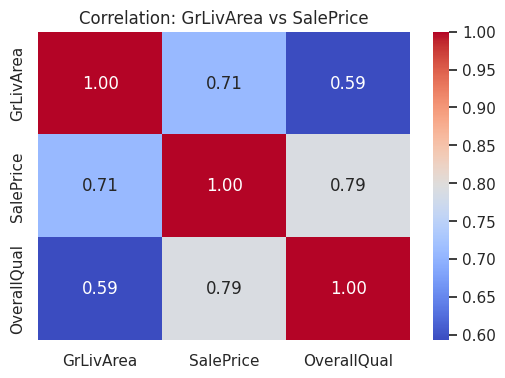

In [14]:
selected_corr = df[['GrLivArea', 'SalePrice', 'OverallQual']].corr(method='pearson')

plt.figure(figsize=(6, 4))
sns.heatmap(selected_corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation: GrLivArea vs SalePrice')
plt.show()

## EDA Conclusions

- Price distribution requires log transformation.
- Strongly correlated features: quality (`OverallQual`), area (`GrLivArea`), garage, basement.
- Gaps in some columns require deletion or filling.
- Some categorical features can be encoded and used.

➡️ Moving on to the next step: **feature engineering and model building.**

# Feature engineering and model building

In [15]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

train_df = train_df.drop(columns=['Id'])
test_ids = test_df['Id']
test_df = test_df.drop(columns=['Id'])
print("File uploaded. Columns:", train_df.columns)

print("Let's take the logarithm of the target feature: SalePrice → LogSalePrice...")
train_df['LogSalePrice'] = np.log1p(train_df['SalePrice'])
print("Column LogSalePrice successfully created")

# Common dataframe for feature processing
full_df = pd.concat([train_df.drop(columns=['SalePrice', 'LogSalePrice']), test_df])

numeric_features = full_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = full_df.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Разеляем
X_train = train_df.drop(columns=['SalePrice', 'LogSalePrice'])
y_train = train_df['LogSalePrice']
X_test = test_df

File uploaded. Columns: Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',


In [16]:
results = {}

## 1. Lasso Regression

In [17]:
lasso_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.01, max_iter=10000))
])
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_train)

results['Lasso'] = {
    "mae": round(mean_absolute_error(y_train, y_pred), 3),
    "mse": round(mean_squared_error(y_train, y_pred), 3),
    "r2": round(r2_score(y_train, y_pred), 3)
}

## 2. Linear Regression

In [18]:
lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_train)

results['LinearRegression'] = {
    "mae": round(mean_absolute_error(y_train, y_pred), 3),
    "mse": round(mean_squared_error(y_train, y_pred), 3),
    "r2": round(r2_score(y_train, y_pred), 3)
}

## 3. Ridge regression

In [19]:
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=10, solver='lsqr'))
])

ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_train)

results['Ridge'] = {
    "mae": round(mean_absolute_error(y_train, y_pred), 3),
    "mse": round(mean_squared_error(y_train, y_pred), 3),
    "r2": round(r2_score(y_train, y_pred), 3)
}

## 4. RandomForest 

In [20]:
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_train)

results['RandomForest'] = {
    "mae": round(mean_absolute_error(y_train, y_pred), 3),
    "mse": round(mean_squared_error(y_train, y_pred), 3),
    "r2": round(r2_score(y_train, y_pred), 3)
}

In [21]:
for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    print(f"  MAE: {metrics['mae']}")
    print(f"  MSE: {metrics['mse']}")
    print(f"  R² : {metrics['r2']}")


Lasso Results:
  MAE: 0.099
  MSE: 0.022
  R² : 0.861

LinearRegression Results:
  MAE: 0.066
  MSE: 0.009
  R² : 0.944

Ridge Results:
  MAE: 0.076
  MSE: 0.013
  R² : 0.921

RandomForest Results:
  MAE: 0.036
  MSE: 0.003
  R² : 0.982


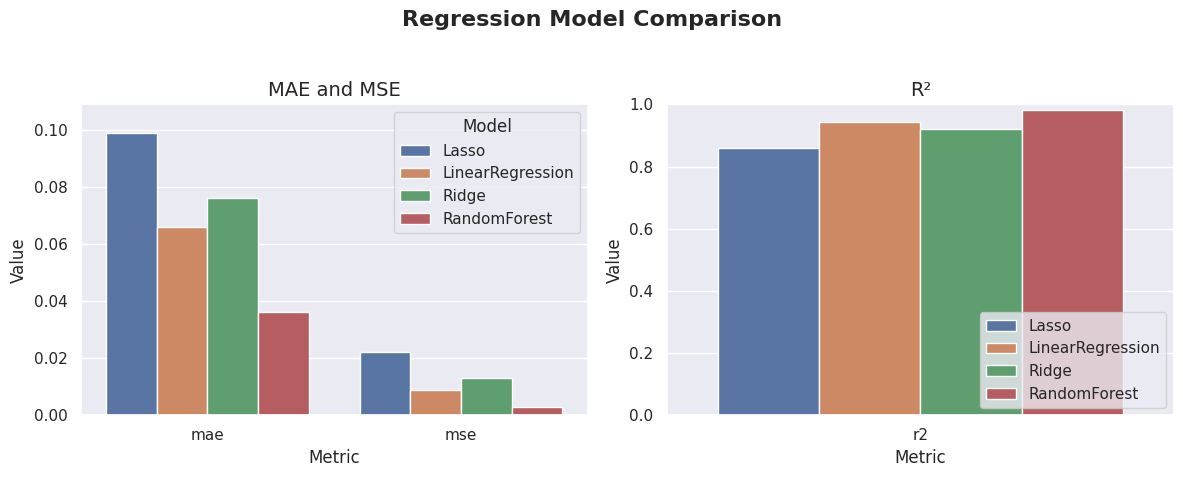

In [22]:
df_metrics = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})
df_long = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Separate MAE and MSE separately from R2
error_df = df_long[df_long['Metric'].isin(['mae', 'mse'])]
r2_df = df_long[df_long['Metric'] == 'r2']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# MAE MSE
sns.barplot(data=error_df, x='Metric', y='Value', hue='Model', ax=axs[0])
axs[0].set_title("MAE and MSE", fontsize=14)
axs[0].set_ylim(0, error_df['Value'].max() * 1.1)

# R2
sns.barplot(data=r2_df, x='Metric', y='Value', hue='Model', ax=axs[1])
axs[1].set_title("R²", fontsize=14)
axs[1].set_ylim(0, 1)

plt.legend(loc='lower right')
plt.suptitle("Regression Model Comparison", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We tested 4 models: Linear Regression, Ridge, Lasso and Random Forest.

According to the metrics (MAE, MSE, R²), **Random Forest shows the best result**. It minimizes errors and predicts the price logarithm as accurately as possible.

**Selected model:** `Random Forest Regressor`

RandomForest Results:

 - MAE: 0.036

 - MSE: 0.003

 - R² : 0.982

This model was used for the final submission, the predictions were scaled to the original scale using `np.expm1()` and saved in `random_forest_submission.csv`.